# MStools - Spectral Peaks from Mass-Spectrographic Data 


## The Classic Approach : Transformation, smooothing, baseline removal, Peak Selection

From speech science, the extraction of so called formants from the speech wave is the Phonetician's daily bread. The first two formants are still the most widely used features when it comes to the description of vowels systems.


Still, the search for peaks in spectral data is not limited to speech science, rather is one common problem in many engineering applications. For example, I have come across some tools from the R world that deal with the extraction of peaks from mass-spectra. I am trying to have a closer look at how it is done in mass-spectrometry, and fiddle around a bit with these approaches in Python... 

The problems are very different conceptually: Du et. al. state early that the methodological challenge is the high rate of false positives caused by noise in mass spectrometry(MS). In other words, there are many meaningful peaks, and these are obscured by measurement noise. This kind of the opposite to speech signals: there are only a handful meaningful vocal tract resonances, and even their localization in the spectrum is constrained by characteristics of the vocal tract. Here the problem is that spectral peaks might be so close together such that they are hard for signal processing teqniques to identify. 

The raw signals in mass spectra are the ion signal as a function of the mass-to-charge ratio, which can be used to determine the elemental or isotopic signature of the sample. In speech acoustics, you start with the acoustic waveform, and therefore, you have already control of the spectral model that you apply. Therefore it is up to the experimenter to for example select the FFT-order prior to perform your application in say formant extraction. 
In this example, say the choice of FFT-order can predispose the smoothness of the spectrum from which you will want to extract formant peaks, left alone the possibility to depart completely from FFT approaches. 
Also it deprives you of the possibility to remove the dominance of lower frequencies already in the raw signal. In speech, this is often done by simple **preemphasis** filters applied to the speech signal, in the simples case, written in Matlab as

         B = [1 -0.95];
         y = filter(B,1,x);

Lacking this possibility, this is compensated by applying baseline removal processing in the spectrum itself. This is rather uncommon in speech science and therefore the most intiguing bit for me. See in particular the paper by Morhac below that is an extension of the snip algorithm. I have implemented that code in pure Python and it is therefore not extremely fast. In an ideal world it would be written in C, but I do not require it to be fast for the moment. 
So to summarize: in mass-spectrometry, more of the signal conditionaing seems to be done in the spectrum itself. While additional smoothing of the spectrum is also done in formant extraction, the amount of smoothing hinges already on how the signal is repsesented. The process if baseline removal from the spectrum seems to be completely unknown to speech scientists. However, these approaches work well and it might be worth a try to experiment with them in formatn estimation. 
I have written basic Python classes for peak picking from mass-spectrographic data, and thesewere inspired by the Maldiquant package for R, and the following demos a kind of standard pipeline consisiting in itensity transformatino by taking the square root, lowpassing, and the aforementioned baseline removal using the snip algorithm. 


### Mass-Spectrographic Peak Picking Demo Pipeline


In [2]:
import unittest
from utils import *
from pprint import pprint as pp
from massSpecObjects import *
from massSpecTools import transformIntensity, smoothIntensity
from massSpecTools import removeBaseline, getSpectralPeaks

SpecNo=1
df = pd.read_csv("data/fiedlerData/"+"Spectrum-"+str(SpecNo).zfill(2)+".csv")
dfPeaks = pd.read_csv("data/fiedlerData/"+"Spectrum-"+str(SpecNo).zfill(2)+".csv")

S1=massSpectrum(mass=df['mass.s1.'], intensity=df['intensity.s1.'])
S2=transformIntensity(S1,method="sqrt")
S3=smoothIntensity(S2,method="SavitzkyGolay")
S4=removeBaseline(S3, method="SNIP")
pks = getSpectralPeaks(S4)

default sqrt
1.66115917577
Index(['mass', 'intensity'], dtype='object')


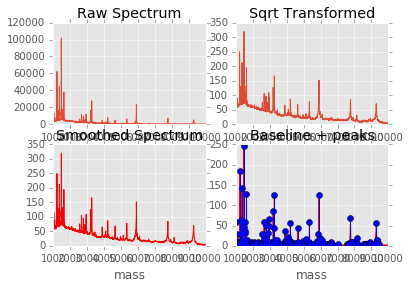

In [3]:
%matplotlib inline  

f, ((ax1, ax2), (ax3, ax4) ) = plt.subplots(2, 2) # , sharex='col', sharey='row'

S1.df.plot(ax=ax1, x="mass", y="intensity",legend=None)
ax1.set_title('Raw Spectrum')
S2.df.plot(ax=ax2, x="mass", y="intensity",legend=None)
ax2.set_title('Sqrt Transformed')
S3.df.plot(ax=ax3, x="mass", y="intensity",legend=None,c='r')
ax3.set_title('Smoothed Spectrum')
S4.df.plot(ax=ax4, x="mass", y="intensity",legend=None,c='r')
ax4.set_title('Baseline + peaks')
ax4.stem(pks.df['mass'], pks.df['intensity'])
plt.show()

## Alternative based on Continuous Wavelet Transforms (Du, Kibbe & Lin, 2006)

The other common approach is based on the Continuous Wavelet Transforms (Du, Kibbe & LIn). So far I have not managed to explore their potential in full glory. There are implementations in Python as well as in R. For the 
latter, there is a package  **MassSpecWavelet** available from bioconductor. For the former, scipy has an implementation. Both packages have lots of options, and for the present purposes, a short preview demoing only the very most importang paramters is in place. 


In [5]:
# Read the R data / generate Spectra
from utils import *
from massSpecObjects import *
import pandas as pd
from scipy.signal import find_peaks_cwt
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import jaccard_similarity_score
matplotlib.style.use('ggplot')

peakIdx = pd.read_csv('data/ExampleMS/Peaks.csv')
spectrum = pd.read_csv('data/ExampleMS/Spectrum.csv')

S1=massSpectrum(mass=list(range(0,len(spectrum))), intensity=spectrum)
dat = S1.df.ix[-1+peakIdx['x']] # correct for R 1 based indexing here!
Peaks= massPeaks(mass=dat.mass, intensity=dat.intensity)



44  but should be  42


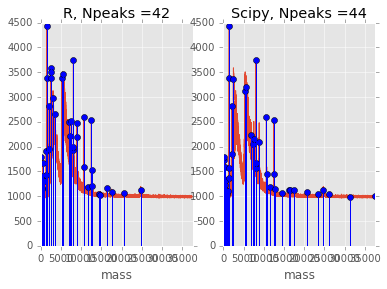

done


In [7]:

scales = np.array([1] + list(range(2,32,2)) + list(range(32,65,4)))
mywavelet = signal.ricker
a_min_snr=3
indexes = find_peaks_cwt(S1.df.intensity,scales,mywavelet,min_snr=a_min_snr)
indexesUse = np.subtract(indexes,1) # again work with R 1 based indexing
print (len(indexes), " but should be ", len(peakIdx))
f, (ax1,ax2) = plt.subplots(1, 2)
S1.df.plot(ax=ax1, x="mass", y="intensity",legend=None) 
ax1.stem(Peaks.df['mass'], Peaks.df['intensity'])
ax1.set_title('R, Npeaks ='+str(len(peakIdx)))
S1.df.plot(ax=ax2, x="mass", y="intensity",legend=None) 
ax2.stem(S1.df.ix[indexesUse]['mass'], S1.df.ix[indexesUse]['intensity'])
ax2.set_title('Scipy, Npeaks ='+str(len(indexes)))
plt.show()
print ("done")


### Comments

Setting only three parameters allows to identify the most important peaks, although the solutions differ a lot at second gaze. Still, there is not a drastic inflation in false positives (44 versus 42 peaks). 
* The Ricker wavelet is the Mexican hat wavelet: see  help(signal.ricker), the default wavelet in the R package 
* Scales of the CWT are taken from the default for the R package
* SNR is also chosen to mimic the R package


# References

C.G. Ryan, E. Clayton, W.L. Griffin, S.H. Sie, and D.R. Cousens. 1988. Snip, a statis-sensitive background treatment for the quantitative analysis of pixe spectra in geoscience applications. Nuclear Instruments and Methods in Physics Research Section B: Beam Interactions with Materials and Atoms, 34(3): 396-402.

M. Morhac. 2009. An algorithm for determination of peak regions and baseline elimination in spectroscopic data. Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment, 600(2), 478-487.

Du, P., Kibbe, W.A. and Lin, S.M. (2006) Improved peak detection in mass spectrum by incorporating continuous wavelet transform-based pattern matching, Bioinformatics, 22, 2059-2065.
